In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/ann_logistic_extra/ecommerce_data.csv')

In [3]:
df

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,time_of_day,user_action
0,1,0,0.657510,0,3,0
1,1,1,0.568571,0,2,1
2,1,0,0.042246,1,1,0
3,1,1,1.659793,1,1,2
4,0,1,2.014745,1,1,2
...,...,...,...,...,...,...
495,1,3,0.731594,0,0,2
496,0,0,6.368775,1,3,0
497,0,0,0.172853,1,3,0
498,1,0,0.209964,0,3,0


In [4]:
def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [5]:
df1 = pd.get_dummies(df,columns=['time_of_day'])#making four categorical columns

In [6]:
df1 = df1[['is_mobile', 'n_products_viewed', 'visit_duration',
       'is_returning_visitor', 'time_of_day_0', 'time_of_day_1',
       'time_of_day_2', 'time_of_day_3','user_action']]  # changing the order of the columns

In [7]:
df1

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3,user_action
0,1,0,0.657510,0,0,0,0,1,0
1,1,1,0.568571,0,0,0,1,0,1
2,1,0,0.042246,1,0,1,0,0,0
3,1,1,1.659793,1,0,1,0,0,2
4,0,1,2.014745,1,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...
495,1,3,0.731594,0,1,0,0,0,2
496,0,0,6.368775,1,0,0,0,1,0
497,0,0,0.172853,1,0,0,0,1,0
498,1,0,0.209964,0,0,0,0,1,0


In [8]:
X = df1.values #converting dataframe to array

In [9]:
X[:,1] = (X[:,1]-X[:,1].mean())/X[:,1].std()#normalising columns because of values greater than one
X[:,2] = (X[:,2]-X[:,2].mean())/X[:,2].std()

In [10]:
#only keeping binary values(0,1) in last column
X1 = X[X[:,-1]<=1]

In [11]:
X2 = X1[:,:-1]#everycolumn but last
Y2 = X1[:,-1]#last column

In [12]:
df = X

In [13]:
def get_data():

  # just in case you're curious what's in it
  # df.head()
  # easier to work with numpy array
    data = df

  # shuffle it
    np.random.shuffle(data)

  # split features and labels
    X = data[:,:-1]
    Y = data[:,-1].astype(np.int32)

  # one-hot encode the categorical data
  # create a new matrix X2 with the correct number of columns
    N, D = X.shape
    X2 = np.zeros((N, D+3))
    X2[:,0:(D-1)] = X[:,0:(D-1)] # non-categorical

  # one-hot
    for n in range(N):
        t = int(X[n,D-1])
        X2[n,t+D-1] = 1

  # method 2
  # Z = np.zeros((N, 4))
  # Z[np.arange(N), X[:,D-1].astype(np.int32)] = 1
  # # assign: X2[:,-4:] = Z
  # assert(np.abs(X2[:,-4:] - Z).sum() < 1e-10)

  # assign X2 back to X, since we don't need original anymore
    X = X2

  # split train and test
    Xtrain = X[:-100]
    Ytrain = Y[:-100]
    Xtest = X[-100:]
    Ytest = Y[-100:]

  # normalize columns 1 and 2
    for i in (1, 2):
        m = Xtrain[:,i].mean()
        s = Xtrain[:,i].std()
        Xtrain[:,i] = (Xtrain[:,i] - m) / s
        Xtest[:,i] = (Xtest[:,i] - m) / s

    return Xtrain, Ytrain, Xtest, Ytest

In [14]:
Xtrain, Ytrain, Xtest, Ytest = get_data()

In [15]:
M = 5
D = Xtrain.shape[1]
K = len(set(Ytrain) | set(Ytest))#no of classes here K=2 because Y2 has two classes (0,1)
W1 = np.random.randn(D, M)#weights before hidden layers
b1 = np.zeros(M)#bias dim of 5X1
W2 = np.random.randn(M, K)#weight  after hidden layers
b2 = np.zeros(K)#bias dim of 2X1

In [16]:
Ytrain_ind = y2indicator(Ytrain, K)
Ytest_ind = y2indicator(Ytest, K)

In [17]:
def softmax(a):
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

In [18]:
def forward(X2, W1, b1, W2, b2):
    Z = np.tanh(X2.dot(W1) + b1)
    return softmax(Z.dot(W2) + b2),Z

In [19]:
def predict(P_Y_given_X):
    return np.argmax(P_Y_given_X, axis=1)

In [20]:
def classification_rate(Y2, P):
    return np.mean(Y2 == P)

In [21]:
def cross_entropy(T, pY):
    return -np.mean(T*np.log(pY))

In [22]:
train_costs = []
test_costs = []
learning_rate = 0.001
for i in range(10000):
    pYtrain, Ztrain = forward(Xtrain, W1, b1, W2, b2)
    pYtest, Ztest = forward(Xtest, W1, b1, W2, b2)
    
    ctrain = cross_entropy(Ytrain_ind, pYtrain)
    ctest = cross_entropy(Ytest_ind, pYtest)
    train_costs.append(ctrain)
    test_costs.append(ctest)
    
    W2 -= learning_rate*Ztrain.T.dot(pYtrain - Ytrain_ind)
    b2 -= learning_rate*(pYtrain - Ytrain_ind).sum(axis=0)
    dZ = (pYtrain - Ytrain_ind).dot(W2.T) * (1 - Ztrain*Ztrain)
    W1 -= learning_rate*Xtrain.T.dot(dZ)
    b1 -= learning_rate*dZ.sum(axis=0)
    if i % 1000 == 0:
        print(i, ctrain, ctest)

0 0.5429672821571377 0.6081579415079296
1000 0.03645622334684744 0.05017367754119565
2000 0.024758899926064837 0.04320131522351997
3000 0.01659679853088627 0.0490256180258433
4000 0.014087684050161912 0.051697153470982436
5000 0.01254661414433902 0.053809725419167814
6000 0.011509992680389897 0.05589750518057564
7000 0.010764881588729812 0.05796856731252285
8000 0.010200800642436314 0.0600279343394617
9000 0.009756434589920038 0.06206245624609258


In [23]:
print("Final train classification_rate:", classification_rate(Ytrain, predict(pYtrain)))
print("Final test classification_rate:", classification_rate(Ytest, predict(pYtest)))

Final train classification_rate: 0.9925
Final test classification_rate: 0.94


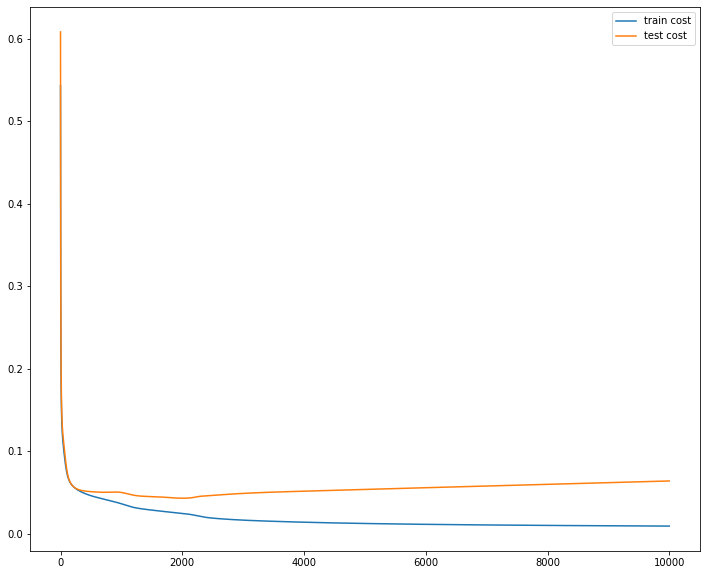

In [24]:
plt.figure(figsize=(12,10))
legend1, = plt.plot(train_costs, label='train cost')
legend2, = plt.plot(test_costs, label='test cost')
labels = ['train cost','test cost']
plt.legend(labels)
plt.show()